In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.units import UnitsWarning
import warnings
from lsst.rsp import get_tap_service, retrieve_query

import healpy as hp
import math
import gc

In [3]:
warnings.simplefilter("ignore", category=UnitsWarning)
pd.set_option('display.max_rows', 200)

In [4]:
%matplotlib inline

In [5]:
service = get_tap_service()

In [88]:
import time
from IPython.display import Image

import numpy
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service

from astropy.cosmology import FlatLambdaCDM

service = get_tap_service()

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

redshift_min = 0.1
redshift_max = 0.3

snia_peak_mag = -19.0
snia_peak_mag_range = 0.5

snia_peak_mr_min = cosmo.distmod(redshift_min).value + snia_peak_mag - snia_peak_mag_range
snia_peak_mr_max = cosmo.distmod(redshift_max).value + snia_peak_mag + snia_peak_mag_range
print('The minimum and maximum apparent r-band magnitudes '
      'to use in the TAP query are %5.2f and %5.2f mag.' %
      (snia_peak_mr_min, snia_peak_mr_max))


snia_peak_mg_max = 24.0
snia_peak_mi_max = 24.0

snia_ampl_mr_min = 1.5
snia_ampl_mr_max = 5.5

snia_nDiaSources_min = 15
snia_nDiaSources_max = 100

snia_duration_min = 50
snia_duration_max = 300

results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin) AS rMagMax, "
                         "scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagMin, "
                         "scisql_nanojanskyToAbMag(gPSFluxMax) AS gMagMin, "
                         "scisql_nanojanskyToAbMag(iPSFluxMax) AS iMagMin, "
                         "scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) AS rMagAmp "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > "+str(snia_nDiaSources_min)+" "
                         "AND nDiaSources < "+str(snia_nDiaSources_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_peak_mr_min)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_peak_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(gPSFluxMax) < "+str(snia_peak_mg_max)+" "
                         "AND scisql_nanojanskyToAbMag(iPSFluxMax) < "+str(snia_peak_mi_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) < "+str(snia_ampl_mr_max)+" "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > "+str(snia_ampl_mr_min)+" ",
                         maxrec=100000)

df_do = results.to_table().to_pandas()
del results

The minimum and maximum apparent r-band magnitudes to use in the TAP query are 18.82 and 22.46 mag.


In [114]:
len(df_do)


6570

In [ ]:
%%time
# This cell takes about 1.5 minutes...

query = """SELECT * FROM dp02_dc2_catalogs.TruthSummary 
           WHERE 
           truth_type=3  
        """

print(query)

results = service.search(query)
df_ts3 = results.to_table().to_pandas()
del results



In [94]:
# Healpix tools.
#  From Sahar Allam (2016.07.08)

##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################


In [101]:
nside=2**17
# Area in sq arcsec:
area = 3600.*3600.*hp.pixelfunc.nside2pixarea(nside, degrees=True)
# A rough measure of length in arcsec: 
length = math.sqrt(area)
print(nside, area, length)

131072 2.593337450489216 1.6103842555394088


In [102]:
df_ts3.loc[:,'HPX_2_17'] = getipix(nside, df_ts3.loc[:,'ra'].values, df_ts3.loc[:,'dec'].values)
len(df_ts3)

445209

In [103]:
df_do.loc[:,'HPX_2_17'] = getipix(nside, df_do.loc[:,'ra'].values, df_do.loc[:,'decl'].values)
len(df_do)

6570

In [104]:
df_merged = pd.merge(df_ts3, df_do, how='inner', on=['HPX_2_17','HPX_2_17'])
len(df_merged)

1086

In [105]:
df_merged


cosmodc2_hp  cosmodc2_id        dec  flux_g  flux_g_noMW  flux_i  \
0              -1           -1 -44.328824     0.0          0.0     0.0   
1              -1           -1 -44.142050     0.0          0.0     0.0   
2              -1           -1 -44.037236     0.0          0.0     0.0   
3              -1           -1 -44.385431     0.0          0.0     0.0   
4              -1           -1 -43.719085     0.0          0.0     0.0   
...           ...          ...        ...     ...          ...     ...   
1081           -1           -1 -27.220548     0.0          0.0     0.0   
1082           -1           -1 -27.371544     0.0          0.0     0.0   
1083           -1           -1 -27.342200     0.0          0.0     0.0   
1084           -1           -1 -27.427588     0.0          0.0     0.0   
1085           -1           -1 -26.905326     0.0          0.0     0.0   

      flux_i_noMW  flux_r  flux_r_noMW  flux_u  ...      HPX_2_17       ra_y  \
0             0.0     0.0          0.0     0.0  ...  144448551187  52.484446   
1             0.0     0.0          0.0     0.0  ...  144285577436  60.290140   
2             0.0     0.0          0.0     0.0  ...  144198923302  60.817692   
3             0.0     0.0          0.0     0.0  ...  142786539275  66.497716   
4             0.0     0.0          0.0     0.0  ...  144473607478  51.625539   
...           ...     ...          ...     ...  ...           ...        ...   
1081          0.0     0.0          0.0     0.0  ...  151425665225  56.634124   
1082          0.0     0.0          0.0     0.0  ...  151425077018  56.645894   
1083          0.0     0.0          0.0     0.0  ...  145736890971  59.972521   
1084          0.0     0.0          0.0     0.0  ...  145710041739  61.766972   
1085          0.0     0.0          0.0     0.0  ...  145828292815  70.103755   

           decl          diaObjectId  nDiaSources    rMagMax    rMagMin  \
0    -44.328815  1249159558362828633           17  24.365925  22.262382   
1    -44.142051  1250953961339360185           27  23.802079  21.703960   
2    -44.037228  1250945165246333735           48  24.481775  21.714324   
3    -44.385426  1252185414362464573           34  24.062093  22.065372   
4    -43.719090  1248878083386114077           43  24.182043  22.172264   
...         ...                  ...          ...        ...        ...   
1081 -27.220553  2183322229507359260           40  24.058715  21.909401   
1082 -27.371550  2183322229507359132           19  24.241338  22.343817   
1083 -27.342204  2184184246623535928           39  23.324958  21.645231   
1084 -27.427584  2184544886437449362           22  23.551747  22.050189   
1085 -26.905324  2186884647181353685           24  23.531971  21.029644   

        gMagMin    iMagMin   rMagAmp  
0     22.700876  22.346450  2.103543  
1     22.552848  21.298092  2.098119  
2     22.110914  21.888761  2.767450  
3     22.632828  21.992463  1.996720  
4     22.780476  22.001834  2.009779  
...         ...        ...       ...  
1081  22.345077  22.101370  2.149314  
1082  22.714664  22.420114  1.897521  
1083  22.536015  21.789440  1.679727  
1084  23.460180  21.889445  1.501558  
1085  23.959144  21.751929  2.502327  

[1086 rows x 34 columns]

0.597694993019104

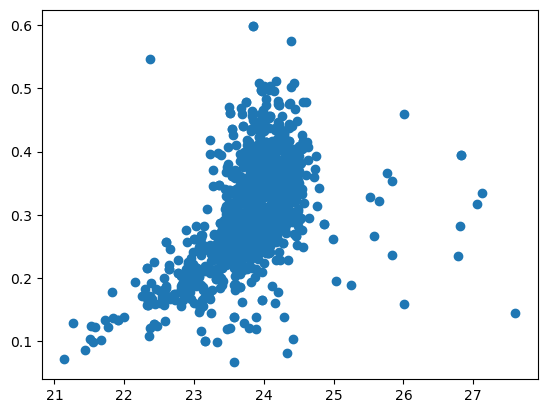

In [108]:
R=df_merged['redshift']
r_mag_max=df_merged['rMagMax']
from matplotlib import pyplot as plt
plt.scatter(r_mag_max,R)
plt.title('r vs mu')
plt.xlabel('r magnitude')
plt.ylabel('redshifts')


In [109]:
df_merged['diff_ra'] = 3600.*(df_merged['ra_x'] - df_merged['ra_y'])
df_merged['diff_dec'] = 3600.*(df_merged['dec'] - df_merged['decl'])

array([[<AxesSubplot:title={'center':'diff_ra'}>]], dtype=object)

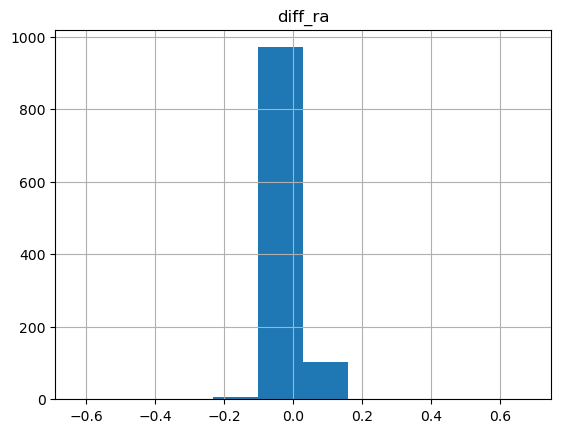

In [110]:
df_merged.hist('diff_ra')

array([[<AxesSubplot:title={'center':'diff_dec'}>]], dtype=object)

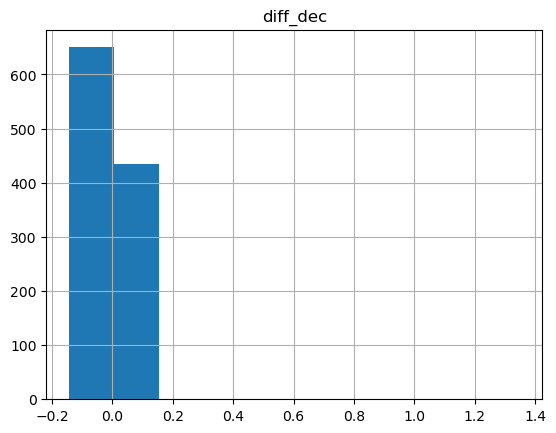

In [111]:
df_merged.hist('diff_dec')